Configuração PyTorch GPU Ubuntu aplicada:
- Dispositivo: cuda
- GPU: NVIDIA GeForce RTX 3060
- VRAM total: 11.6 GB
- CUDA version: 12.1
- Teste GPU concluído! Resultado: -0.000676
GPU PyTorch funcionando perfeitamente!
PyTorch version: 2.5.1+cu121
Reprodutibilidade configurada
Configurações definidas:
- Tamanho da imagem: 224x224
- Batch size: 32
- Épocas máximas: 100
- Classes de emoção: 7
Iniciando treinamento ResNet50 PyTorch definitivo...
Sistema preparado para GPU acelerada!
TREINAMENTO RESNET50 PYTORCH - VERSÃO DEFINITIVA
Experimento iniciado: resnet50_pytorch_emotion_20250916_193523

Carregando dataset...
Carregando dados pré-processados JPG para ResNet50 PyTorch...
🔍 Analisando estrutura de: /home/leandro/Documents/TCC/emotion_recognition_tcc/data/augmented/raf_db_balanced
📁 Diretórios: ['test', 'train']
📄 Arquivos: 0 encontrados
✅ Estrutura detectada: train/test/emotion/
Carregando TREINO de: /home/leandro/Documents/TCC/emotion_recognition_tcc/data/augmented/raf_db_balanced/tr

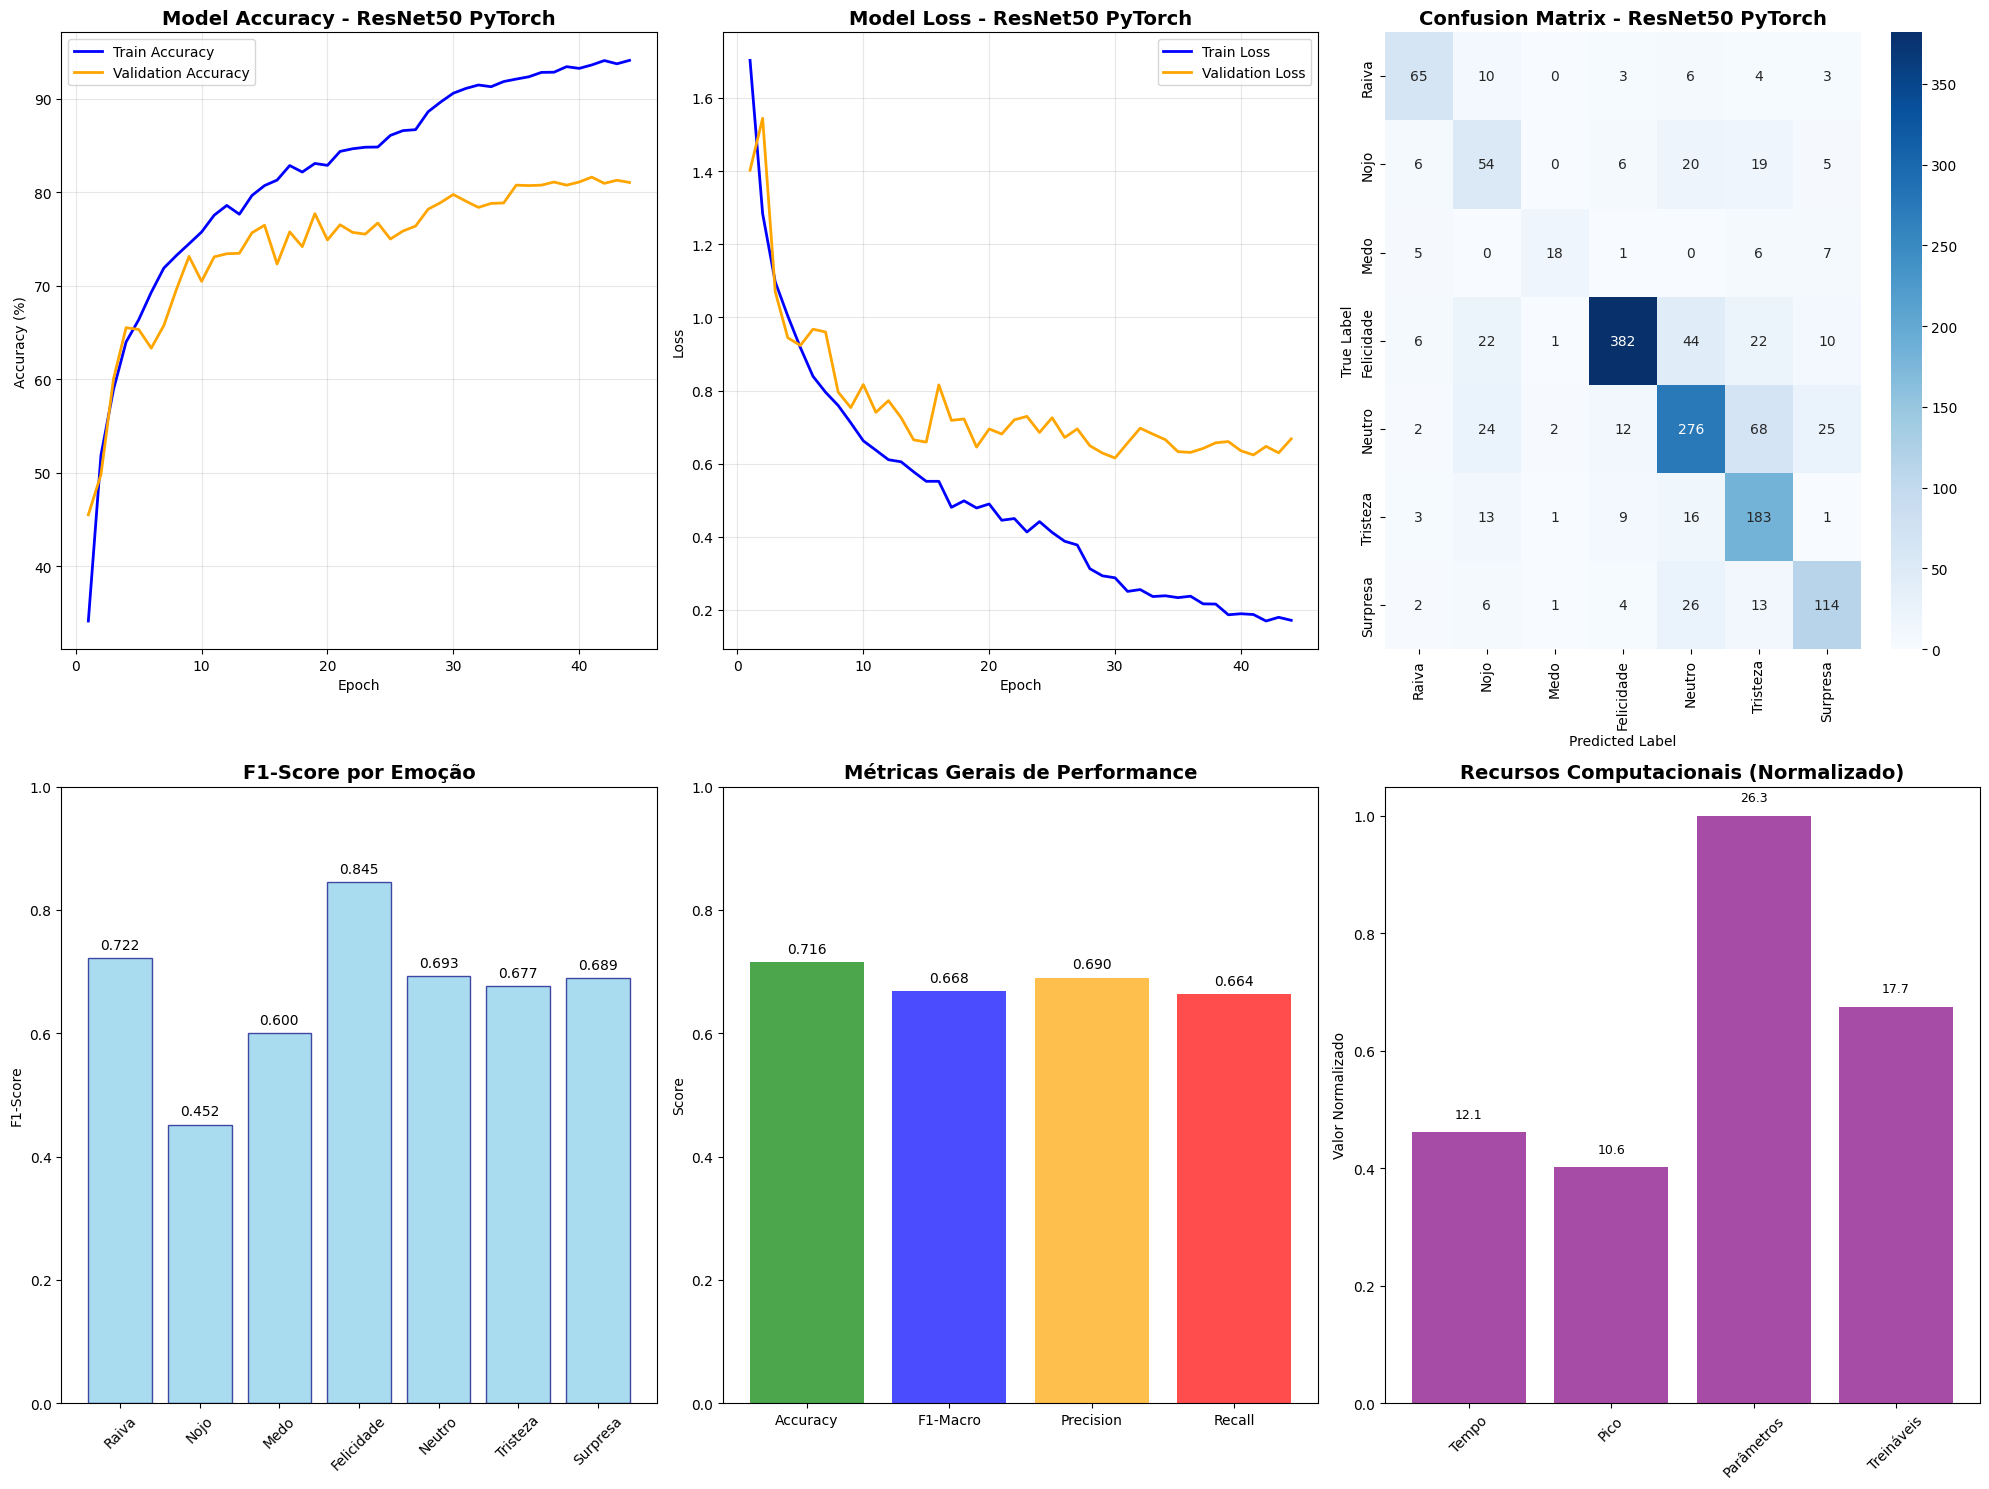


Visualizações salvas em: plots/comprehensive_analysis_pytorch_resnet50_pytorch_emotion_20250916_193523.png

EXPERIMENTO CONCLUÍDO COM SUCESSO!
ID do Experimento: resnet50_pytorch_emotion_20250916_193523
Modelo PyTorch salvo: Sim
Caminho do modelo: models/resnet50_pytorch_resnet50_pytorch_emotion_20250916_193523.pth
Métricas salvas em: metrics/
Gráficos salvos em: plots/

🎉 TREINAMENTO PYTORCH CONCLUÍDO COM SUCESSO!
📊 Resumo dos Resultados:
   - Experimento ID: resnet50_pytorch_emotion_20250916_193523
   - Acurácia Final: 0.7156 (71.56%)
   - Melhor Val Acc: 0.8162 (81.62%)
   - F1-Score Macro: 0.6682
   - Tempo de Treinamento: 12.1 minutos
   - Épocas Executadas: 44
   - Dispositivo: cuda
   - Modelo Salvo: ✅ Sim

📁 Arquivos Gerados:
   - Métricas: metrics/performance_metrics_pytorch.csv
   - Modelo: models/resnet50_pytorch_resnet50_pytorch_emotion_20250916_193523.pth
   - Gráficos: plots/comprehensive_analysis_pytorch_resnet50_pytorch_emotion_20250916_193523.png

✅ PERFORMANCE SATISF

In [ ]:
# ResNet50 PyTorch - Versão Completa e Definitiva
# Adaptado do notebook TensorFlow original

import os
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import pandas as pd
import cv2
from datetime import datetime, timedelta
import random
import time
import psutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pickle
import gc

# Verificação e configuração GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Configuração PyTorch GPU Ubuntu aplicada:")
print(f"- Dispositivo: {device}")
if torch.cuda.is_available():
    print(f"- GPU: {torch.cuda.get_device_name(0)}")
    print(f"- VRAM total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"- CUDA version: {torch.version.cuda}")
    # Teste para verificar GPU funcional
    test_tensor = torch.randn(1000, 1000).to(device)
    result = torch.mean(test_tensor)
    print(f"- Teste GPU concluído! Resultado: {result.item():.6f}")
    print("GPU PyTorch funcionando perfeitamente!")
else:
    print("Usando CPU - funcional mas mais lento")

# Configuração de reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"PyTorch version: {torch.__version__}")
print(f"Reprodutibilidade configurada")

# Configurações do experimento (mantidas do original)
IMG_SIZE = 224
BATCH_SIZE = 32 if torch.cuda.is_available() else 16  # Maior para GPU
EPOCHS = 100
VALIDATION_SPLIT = 0.3

# Caminhos dos datasets (mantidos do original)
BASE_PATH = "/home/leandro/Documents/TCC/emotion_recognition_tcc/data/augmented/raf_db_balanced"

# Mapeamento das 7 emoções básicas (mantido do original)
EMOTION_LABELS = {
    'Raiva': 0, 'Nojo': 1, 'Medo': 2, 'Felicidade': 3, 
    'Neutro': 4, 'Tristeza': 5, 'Surpresa': 6
}

print("Configurações definidas:")
print(f"- Tamanho da imagem: {IMG_SIZE}x{IMG_SIZE}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Épocas máximas: {EPOCHS}")
print(f"- Classes de emoção: {len(EMOTION_LABELS)}")

class TrainingMonitor:
    """
    Classe para monitorar desempenho computacional durante o treinamento.
    Essencial para experimentos científicos reproduzíveis.
    """
    
    def __init__(self):
        self.start_time = None
        self.end_time = None
        self.peak_memory_mb = 0
        self.initial_memory_mb = 0
        self.process = psutil.Process()
        
    def start_monitoring(self):
        """Inicia o monitoramento de tempo e memória"""
        self.start_time = time.time()
        self.initial_memory_mb = self._get_memory_usage()
        self.peak_memory_mb = self.initial_memory_mb
        print(f"Iniciando treinamento ResNet50 PyTorch...")
        print(f"Horário de início: {time.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Memória inicial: {self.initial_memory_mb:.2f} MB")
        print("-" * 50)
        
    def _get_memory_usage(self):
        """Retorna uso atual de memória em MB"""
        return self.process.memory_info().rss / 1024 / 1024
        
    def update_peak_memory(self):
        """Atualiza o pico de memória se necessário"""
        current_memory = self._get_memory_usage()
        if current_memory > self.peak_memory_mb:
            self.peak_memory_mb = current_memory

    def end_monitoring(self):
        """Finaliza monitoramento e retorna estatísticas"""
        self.end_time = time.time()
        total_time = self.end_time - self.start_time
        
        stats = {
            'total_time_seconds': total_time,
            'total_time_formatted': str(timedelta(seconds=int(total_time))),
            'peak_memory_mb': self.peak_memory_mb,
            'initial_memory_mb': self.initial_memory_mb
        }
        
        print(f"\nMonitoramento finalizado:")
        print(f"- Tempo total: {stats['total_time_formatted']}")
        print(f"- Pico de memória: {self.peak_memory_mb:.2f} MB")
        
        return stats

# Instancia o monitor
monitor = TrainingMonitor()

class EmotionDataset(Dataset):
    """Dataset personalizado para emoções com melhorias"""
    
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
        # Analisa distribuição de classes
        self.class_counts = Counter(labels)
        print("Distribuição de classes no dataset:")
        emotion_names = list(EMOTION_LABELS.keys())
        for class_idx, count in sorted(self.class_counts.items()):
            print(f"  {emotion_names[class_idx]}: {count} amostras")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Garante que a imagem seja numpy array
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        
        # Normaliza para [0,255] se estiver em [0,1]
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

def load_preprocessed_data_resnet50_pytorch():
    """
    Carrega dados pré-processados de imagens JPG para PyTorch ResNet50.
    Mantém a mesma estrutura do código TensorFlow original.
    """
    print("Carregando dados pré-processados JPG para ResNet50 PyTorch...")
    
    def load_images_from_directory(directory_path, set_name):
        """Carrega imagens de um diretório"""
        images = []
        labels = []
        
        print(f"Carregando {set_name} de: {directory_path}")
        
        if not os.path.exists(directory_path):
            print(f"❌ Diretório não encontrado: {directory_path}")
            return np.array([]), np.array([])
        
        subdirs = [d for d in os.listdir(directory_path) 
                  if os.path.isdir(os.path.join(directory_path, d))]
        print(f"📁 Subdiretórios encontrados: {subdirs}")
        
        for emotion, label in EMOTION_LABELS.items():
            emotion_path = os.path.join(directory_path, emotion)
            
            if not os.path.exists(emotion_path):
                print(f"⚠️  Pasta '{emotion}' não encontrada em {directory_path}")
                continue
            
            # Método mais robusto para encontrar imagens
            image_files = []
            
            # Lista todos os arquivos no diretório
            try:
                all_files = os.listdir(emotion_path)
                # Filtra apenas arquivos de imagem
                for file in all_files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                        full_path = os.path.join(emotion_path, file)
                        if os.path.isfile(full_path):
                            image_files.append(full_path)
            except Exception as e:
                print(f"    ❌ Erro ao listar arquivos em {emotion_path}: {e}")
                continue
            
            print(f"  📸 {emotion}: {len(image_files)} arquivos encontrados")
            
            if len(image_files) == 0:
                print(f"    ⚠️ Nenhum arquivo de imagem encontrado em {emotion_path}")
                continue
            
            count = 0
            for img_file in image_files:
                try:
                    img = cv2.imread(img_file)
                    if img is None:
                        print(f"    ⚠️ Não foi possível carregar: {os.path.basename(img_file)}")
                        continue
                    
                    # Converte BGR para RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    
                    # Redimensiona
                    if img.shape[:2] != (IMG_SIZE, IMG_SIZE):
                        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
                    
                    # Garante RGB
                    if len(img.shape) == 2:
                        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                    elif img.shape[2] == 1:
                        img = np.repeat(img, 3, axis=2)
                    elif img.shape[2] == 4:
                        img = img[:, :, :3]
                    
                    images.append(img)
                    labels.append(label)
                    count += 1
                    
                except Exception as e:
                    print(f"    ❌ Erro ao carregar {os.path.basename(img_file)}: {e}")
                    continue
            
            print(f"  ✅ {emotion}: {count} imagens carregadas com sucesso")
            
            # Diagnóstico se carregou menos que esperado
            if count < 900:  # Se tem menos de 900 imagens para treino
                print(f"    ⚠️ Esperava ~1000+ imagens, carregou apenas {count}")
        
        print(f"\nTotal carregado para {set_name}: {len(images)} imagens")
        return np.array(images), np.array(labels)
    
    def detect_data_structure(base_path):
        """Detecta a estrutura dos dados automaticamente"""
        print(f"🔍 Analisando estrutura de: {base_path}")
        
        if not os.path.exists(base_path):
            print(f"❌ Caminho base não existe: {base_path}")
            return None
            
        contents = os.listdir(base_path)
        dirs = [d for d in contents if os.path.isdir(os.path.join(base_path, d))]
        files = [f for f in contents if os.path.isfile(os.path.join(base_path, f))]
        
        print(f"📁 Diretórios: {dirs}")
        print(f"📄 Arquivos: {len(files)} encontrados")
        
        if 'train' in dirs and 'test' in dirs:
            print("✅ Estrutura detectada: train/test/emotion/")
            return 'train_test'
        
        emotion_names = set(EMOTION_LABELS.keys())
        found_emotions = set(dirs) & emotion_names
        
        if found_emotions:
            print(f"✅ Estrutura detectada: emotion/ direta - Emoções: {found_emotions}")
            return 'emotion_direct'
        
        print("⚠️ Estrutura não reconhecida automaticamente")
        return 'unknown'
    
    try:
        structure = detect_data_structure(BASE_PATH)
        
        if structure == 'train_test':
            train_path = os.path.join(BASE_PATH, "train")
            test_path = os.path.join(BASE_PATH, "test")
            
            X_train, y_train = load_images_from_directory(train_path, "TREINO")
            X_test, y_test = load_images_from_directory(test_path, "TESTE")
            
        elif structure == 'emotion_direct':
            print("📊 Carregando todas as imagens e criando divisão train/test...")
            
            all_images, all_labels = load_images_from_directory(BASE_PATH, "TODAS AS IMAGENS")
            
            if len(all_images) == 0:
                print("❌ Nenhuma imagem carregada!")
                return None, None, None, None
            
            X_train, X_test, y_train, y_test = train_test_split(
                all_images, all_labels,
                test_size=0.2,
                stratify=all_labels,
                random_state=42
            )
            
            print("✅ Divisão train/test criada automaticamente (80/20)")
            
        else:
            print("❌ Estrutura de dados não suportada!")
            return None, None, None, None
        
        if len(X_train) == 0 or len(X_test) == 0:
            print("❌ Nenhuma imagem carregada. Verifique os caminhos!")
            return None, None, None, None
        
        print(f"\n📊 Dados carregados com sucesso:")
        print(f"- X_train: {X_train.shape}")
        print(f"- y_train: {y_train.shape}")
        print(f"- X_test: {X_test.shape}")
        print(f"- y_test: {y_test.shape}")
        
        # Normalização para PyTorch: [0, 255] -> [0, 1] (feita nas transformações)
        X_train = X_train.astype(np.float32)
        X_test = X_test.astype(np.float32)
        
        print("✅ Normalização será aplicada nas transformações PyTorch")
        
        # Verifica distribuição de classes
        train_distribution = dict(Counter(y_train))
        test_distribution = dict(Counter(y_test))
        
        print(f"\n📈 Distribuição de classes:")
        emotion_names = list(EMOTION_LABELS.keys())
        print("- Treino:")
        for label, count in train_distribution.items():
            emotion_name = emotion_names[label]
            print(f"  {emotion_name}: {count} imagens")
        
        print("- Teste:")
        for label, count in test_distribution.items():
            emotion_name = emotion_names[label]
            print(f"  {emotion_name}: {count} imagens")
        
        return X_train, y_train, X_test, y_test
        
    except Exception as e:
        print(f"❌ Erro ao carregar dados: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

class ImprovedEmotionResNet50(nn.Module):
    """ResNet50 melhorado para classificação de emoções com correções de desbalanceamento"""
    
    def __init__(self, num_classes=7, dropout_rate=0.5):
        super(ImprovedEmotionResNet50, self).__init__()
        
        # Carrega ResNet50 pré-treinado
        self.resnet50 = models.resnet50(weights='IMAGENET1K_V2')  # Pesos mais recentes
        
        # Congela camadas base para transfer learning
        for param in self.resnet50.parameters():
            param.requires_grad = False
        
        # Descongelar algumas camadas finais para fine-tuning
        for param in self.resnet50.layer4.parameters():
            param.requires_grad = True
        
        # Substitui classificador com melhorias
        num_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(dropout_rate * 0.7),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate * 0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.resnet50(x)

def create_experiment_structure():
    """Cria estrutura de diretórios para salvar modelos e métricas."""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    experiment_id = f"resnet50_pytorch_emotion_{timestamp}"
    
    os.makedirs("models", exist_ok=True)
    os.makedirs("metrics", exist_ok=True)
    os.makedirs("plots", exist_ok=True)
    
    return experiment_id

def save_model_if_good_performance(model, accuracy, f1_score, experiment_id, threshold=0.75):
    """Salva modelo PyTorch apenas se a performance for boa."""
    
    if accuracy >= threshold or f1_score >= threshold:
        model_path = f"models/resnet50_pytorch_{experiment_id}.pth"
        
        # Salva estado completo do modelo
        torch.save({
            'model_state_dict': model.state_dict(),
            'accuracy': accuracy,
            'f1_score': f1_score,
            'experiment_id': experiment_id,
            'timestamp': datetime.now().isoformat(),
            'architecture': 'ResNet50_PyTorch',
            'img_size': IMG_SIZE,
            'num_classes': 7
        }, model_path)
        
        print(f"Modelo salvo! Performance: Acc={accuracy:.4f}, F1={f1_score:.4f}")
        return True, model_path
    else:
        print(f"Performance insuficiente para salvar. Acc={accuracy:.4f}, F1={f1_score:.4f} < {threshold}")
        return False, None

def save_metrics_to_csv(metrics_dict, experiment_id):
    """Salva métricas de performance em arquivo CSV."""
    
    metrics_df = pd.DataFrame([metrics_dict])
    
    csv_path = "metrics/performance_metrics_pytorch.csv"
    
    if os.path.exists(csv_path):
        metrics_df.to_csv(csv_path, mode='a', header=False, index=False)
    else:
        metrics_df.to_csv(csv_path, index=False)
    
    individual_csv = f"metrics/metrics_{experiment_id}.csv"
    metrics_df.to_csv(individual_csv, index=False)
    
    print(f"Métricas salvas em: {csv_path} e {individual_csv}")

def train_resnet50_pytorch():
    """Função principal de treinamento com PyTorch"""
    
    print("="*60)
    print("TREINAMENTO RESNET50 PYTORCH - VERSÃO DEFINITIVA")
    print("="*60)
    
    # Cria estrutura do experimento
    experiment_id = create_experiment_structure()
    print(f"Experimento iniciado: {experiment_id}")
    
    # Carrega dados
    print("\nCarregando dataset...")
    X_train, y_train, X_test, y_test = load_preprocessed_data_resnet50_pytorch()
    
    if X_train is None:
        print("Falha no carregamento dos dados")
        return None
    
    monitor.update_peak_memory()
    
    # Split treino/validação
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train,
        test_size=VALIDATION_SPLIT,
        stratify=y_train,
        random_state=42
    )
    
    print(f"\nDados preparados:")
    print(f"- Treino: {X_train_split.shape}")
    print(f"- Validação: {X_val.shape}")
    print(f"- Teste: {X_test.shape}")
    
    # Transformações com melhorias para balanceamento
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    
    val_test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Datasets
    train_dataset = EmotionDataset(X_train_split, y_train_split, transform=train_transform)
    val_dataset = EmotionDataset(X_val, y_val, transform=val_test_transform)
    test_dataset = EmotionDataset(X_test, y_test, transform=val_test_transform)
    
    # Calcula pesos de classe para balanceamento
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_split), y=y_train_split)
    class_weights = torch.FloatTensor(class_weights).to(device)
    print(f"Pesos de classe calculados: {class_weights}")
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                             num_workers=4, pin_memory=True if torch.cuda.is_available() else False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                           num_workers=4, pin_memory=True if torch.cuda.is_available() else False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                            num_workers=4, pin_memory=True if torch.cuda.is_available() else False)
    
    # Modelo melhorado
    print("\nCriando modelo ResNet50 melhorado...")
    model = ImprovedEmotionResNet50().to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Modelo criado com sucesso:")
    print(f"- Total de parâmetros: {total_params:,}")
    print(f"- Parâmetros treináveis: {trainable_params:,}")
    print(f"- Dispositivo: {device}")
    
    # Loss com pesos de classe e otimizador melhorado
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.3)
    
    # Treinamento
    monitor.start_monitoring()
    
    best_val_accuracy = 0.0
    best_model_state = None
    train_history = {
        'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
    }
    
    print(f"\nIniciando treinamento...")
    print(f"Configuração: Batch={BATCH_SIZE}, Epochs={EPOCHS}, Device={device}")
    
    for epoch in range(EPOCHS):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            
            # Gradient clipping para estabilidade
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
            
            if batch_idx % 20 == 0:
                print(f'Época {epoch+1}/{EPOCHS}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}, Acc: {100*correct_train/total_train:.2f}%')
        
        # Métricas de treino
        epoch_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        
        # Validação
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()
        
        val_accuracy = 100 * correct_val / total_val
        val_loss = val_loss / len(val_loader)
        
        # Salva histórico
        train_history['train_loss'].append(epoch_train_loss)
        train_history['train_acc'].append(train_accuracy)
        train_history['val_loss'].append(val_loss)
        train_history['val_acc'].append(val_accuracy)
        
        # Scheduler step
        scheduler.step(val_loss)
        
        # Print resultado da época
        print(f'\nÉpoca {epoch+1}/{EPOCHS}:')
        print(f'  Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
        print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Salva melhor modelo
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict().copy()
            print(f'  ✓ Novo melhor modelo: {val_accuracy:.2f}%')
        
        # Atualiza memória
        monitor.update_peak_memory()
        
        print("-" * 60)
        
        # Early stopping
        if len(train_history['val_acc']) > 15:
            recent_accs = train_history['val_acc'][-10:]
            if max(recent_accs) - min(recent_accs) < 1.0:
                print("Early stopping: sem melhoria significativa")
                break
    
    # Restaura melhor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Modelo restaurado para melhor performance: {best_val_accuracy:.2f}%")
    
    # Avaliação final no conjunto de teste
    print("\n" + "="*60)
    print("AVALIAÇÃO FINAL NO CONJUNTO DE TESTE")
    print("="*60)
    
    model.eval()
    all_predictions = []
    all_targets = []
    test_loss = 0.0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Métricas finais
    final_accuracy = accuracy_score(all_targets, all_predictions)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_targets, all_predictions, average='macro', zero_division=0
    )
    
    # Finaliza monitoramento
    monitor_stats = monitor.end_monitoring()
    
    # Métricas completas
    emotion_names = list(EMOTION_LABELS.keys())
    class_report = classification_report(all_targets, all_predictions, 
                                       target_names=emotion_names, 
                                       output_dict=True)
    
    conf_matrix = confusion_matrix(all_targets, all_predictions)
    
    # Compilação das métricas para salvar
    comprehensive_metrics = {
        'experiment_id': experiment_id,
        'model_architecture': 'ResNet50_PyTorch_Improved',
        'timestamp': datetime.now().isoformat(),
        'device': str(device),
        
        # Configurações
        'img_size': IMG_SIZE,
        'batch_size': BATCH_SIZE,
        'epochs_trained': epoch + 1,
        'best_val_accuracy': best_val_accuracy / 100,
        
        # Performance principal
        'test_accuracy': final_accuracy,
        'f1_score_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall,
        
        # Tempo e recursos
        'training_time_seconds': monitor_stats['total_time_seconds'],
        'peak_memory_mb': monitor_stats['peak_memory_mb'],
        
        # Dados do dataset
        'train_samples': len(X_train_split),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
        'total_parameters': total_params,
        'trainable_parameters': trainable_params,
        
        # Métricas por emoção
        'raiva_f1': class_report['Raiva']['f1-score'],
        'nojo_f1': class_report['Nojo']['f1-score'],
        'medo_f1': class_report['Medo']['f1-score'],
        'felicidade_f1': class_report['Felicidade']['f1-score'],
        'neutro_f1': class_report['Neutro']['f1-score'],
        'tristeza_f1': class_report['Tristeza']['f1-score'],
        'surpresa_f1': class_report['Surpresa']['f1-score']
    }
    
    # Salva métricas
    save_metrics_to_csv(comprehensive_metrics, experiment_id)
    
    # Salva modelo se boa performance
    model_saved, model_path = save_model_if_good_performance(
        model, final_accuracy, f1, experiment_id, threshold=0.70
    )
    
    # Relatório final detalhado
    print(f"Acurácia Final: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
    print(f"Melhor Val Acc: {best_val_accuracy:.2f}%")
    print(f"F1-Score Macro: {f1:.4f}")
    print(f"Precision Macro: {precision:.4f}")
    print(f"Recall Macro: {recall:.4f}")
    print(f"Tempo Total: {monitor_stats['total_time_seconds']/60:.1f} minutos")
    print(f"Épocas Executadas: {epoch+1}")
    print(f"Dispositivo Usado: {device}")
    
    print(f"\nRelatório por Emoção:")
    for emotion in emotion_names:
        f1_score = class_report[emotion]['f1-score']
        precision_score = class_report[emotion]['precision']
        recall_score = class_report[emotion]['recall']
        print(f"  {emotion}: F1={f1_score:.3f}, Precision={precision_score:.3f}, Recall={recall_score:.3f}")
    
    print(f"\nMatriz de Confusão:")
    print(conf_matrix)
    
    # Análise de desbalanceamento
    print(f"\nAnálise de Desbalanceamento:")
    for i, emotion in enumerate(emotion_names):
        true_positives = conf_matrix[i, i]
        total_true = conf_matrix[i, :].sum()
        support = total_true
        print(f"  {emotion}: {support} amostras (TP: {true_positives})")
    
    # Cria visualizações
    create_comprehensive_visualizations_pytorch(
        train_history, conf_matrix, comprehensive_metrics, class_report, experiment_id
    )
    
    # Limpeza final
    del model, train_loader, val_loader, test_loader
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    gc.collect()
    
    print(f"\n" + "="*80)
    print(f"EXPERIMENTO CONCLUÍDO COM SUCESSO!")
    print(f"ID do Experimento: {experiment_id}")
    print(f"Modelo PyTorch salvo: {'Sim' if model_saved else 'Não'}")
    if model_saved:
        print(f"Caminho do modelo: {model_path}")
    print(f"Métricas salvas em: metrics/")
    print(f"Gráficos salvos em: plots/")
    print(f"="*80)
    
    return {
        'experiment_id': experiment_id,
        'final_accuracy': final_accuracy,
        'best_val_accuracy': best_val_accuracy/100,
        'f1_macro': f1,
        'training_time': monitor_stats['total_time_seconds'],
        'epochs_run': epoch+1,
        'model_saved': model_saved,
        'device_used': str(device)
    }

def create_comprehensive_visualizations_pytorch(history, conf_matrix, metrics, class_report, experiment_id):
    """Cria visualizações completas dos resultados para análise científica PyTorch"""
    
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Histórico de treinamento
    ax1 = plt.subplot(2, 3, 1)
    epochs_range = range(1, len(history['train_acc']) + 1)
    plt.plot(epochs_range, history['train_acc'], label='Train Accuracy', linewidth=2, color='blue')
    plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy', linewidth=2, color='orange')
    plt.title('Model Accuracy - ResNet50 PyTorch', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    ax2 = plt.subplot(2, 3, 2)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss', linewidth=2, color='blue')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
    plt.title('Model Loss - ResNet50 PyTorch', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Matriz de confusão
    ax3 = plt.subplot(2, 3, 3)
    emotion_names = list(EMOTION_LABELS.keys())
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_names, yticklabels=emotion_names, ax=ax3)
    plt.title('Confusion Matrix - ResNet50 PyTorch', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 3. F1-Score por classe
    ax4 = plt.subplot(2, 3, 4)
    f1_scores = [class_report[emotion]['f1-score'] for emotion in emotion_names]
    bars = plt.bar(emotion_names, f1_scores, color='skyblue', edgecolor='navy', alpha=0.7)
    plt.title('F1-Score por Emoção', fontsize=14, fontweight='bold')
    plt.ylabel('F1-Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    for bar, score in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    # 4. Métricas gerais de performance
    ax5 = plt.subplot(2, 3, 5)
    performance_metrics = ['Accuracy', 'F1-Macro', 'Precision', 'Recall']
    performance_values = [
        metrics['test_accuracy'],
        metrics['f1_score_macro'],
        metrics['precision_macro'],
        metrics['recall_macro']
    ]
    bars = plt.bar(performance_metrics, performance_values, 
                  color=['green', 'blue', 'orange', 'red'], alpha=0.7)
    plt.title('Métricas Gerais de Performance', fontsize=14, fontweight='bold')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    
    for bar, value in zip(bars, performance_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    # 5. Análise de recursos computacionais
    ax6 = plt.subplot(2, 3, 6)
    resource_data = {
        'Tempo Treino (min)': metrics['training_time_seconds'] / 60,
        'Pico Memória (GB)': metrics['peak_memory_mb'] / 1024,
        'Parâmetros (M)': metrics['total_parameters'] / 1_000_000,
        'Treináveis (M)': metrics['trainable_parameters'] / 1_000_000
    }
    
    # Normaliza para visualização
    max_val = max(resource_data.values())
    normalized_values = [v / max_val for v in resource_data.values()]
    
    bars = plt.bar(range(len(resource_data)), normalized_values, color='purple', alpha=0.7)
    plt.title('Recursos Computacionais (Normalizado)', fontsize=14, fontweight='bold')
    plt.xticks(range(len(resource_data)), 
               [key.split(' ')[0] for key in resource_data.keys()], rotation=45)
    plt.ylabel('Valor Normalizado')
    
    # Adiciona valores reais
    for i, (bar, (key, value)) in enumerate(zip(bars, resource_data.items())):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{value:.1f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(f'plots/comprehensive_analysis_pytorch_{experiment_id}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nVisualizações salvas em: plots/comprehensive_analysis_pytorch_{experiment_id}.png")


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from datetime import timedelta

def create_comprehensive_visualizations_efficientnet_pytorch(history, conf_matrix, metrics, class_report, experiment_id, y_true, y_pred):
    """
    Cria visualizações completas dos resultados EfficientNet PyTorch com foco em dados desbalanceados
    
    Args:
        history: Histórico de treinamento
        conf_matrix: Matriz de confusão
        metrics: Métricas do modelo
        class_report: Relatório de classificação
        experiment_id: ID do experimento
        y_true: Labels verdadeiros
        y_pred: Predições do modelo
    """
    
    # Configuração da figura
    fig = plt.figure(figsize=(24, 18))
    
    # 1. HISTÓRICO DE TREINAMENTO EM 2 FASES
    ax1 = plt.subplot(3, 4, 1)
    epochs_phase1 = range(1, history['phase1_epochs'] + 1)
    epochs_phase2 = range(history['phase1_epochs'] + 1, 
                         history['phase1_epochs'] + history['phase2_epochs'] + 1)
    
    # Plotar accuracy por fase
    plt.plot(epochs_phase1, history['train_acc'][:history['phase1_epochs']], 
             'b-', linewidth=2, label='Fase 1 - Train')
    plt.plot(epochs_phase1, history['val_acc'][:history['phase1_epochs']], 
             'b--', linewidth=2, label='Fase 1 - Val')
    plt.plot(epochs_phase2, history['train_acc'][history['phase1_epochs']:], 
             'r-', linewidth=2, label='Fase 2 - Train')
    plt.plot(epochs_phase2, history['val_acc'][history['phase1_epochs']:], 
             'r--', linewidth=2, label='Fase 2 - Val')
    
    plt.axvline(x=history['phase1_epochs'], color='gray', linestyle=':', alpha=0.7, 
                label='Phase Transition')
    plt.title('EfficientNet: Accuracy - 2 Phases', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. LOSS EM 2 FASES
    ax2 = plt.subplot(3, 4, 2)
    plt.plot(epochs_phase1, history['train_loss'][:history['phase1_epochs']], 
             'b-', linewidth=2, label='Fase 1 - Train')
    plt.plot(epochs_phase1, history['val_loss'][:history['phase1_epochs']], 
             'b--', linewidth=2, label='Fase 1 - Val')
    plt.plot(epochs_phase2, history['train_loss'][history['phase1_epochs']:], 
             'r-', linewidth=2, label='Fase 2 - Train')
    plt.plot(epochs_phase2, history['val_loss'][history['phase1_epochs']:], 
             'r--', linewidth=2, label='Fase 2 - Val')
    
    plt.axvline(x=history['phase1_epochs'], color='gray', linestyle=':', alpha=0.7)
    plt.title('EfficientNet: Loss - 2 Phases', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. MATRIZ DE CONFUSÃO RAW (DESBALANCEADA)
    ax3 = plt.subplot(3, 4, 3)
    emotion_names = list(EMOTION_LABELS.keys())
    
    # Matriz bruta mostra o desbalanceamento
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_names, yticklabels=emotion_names, ax=ax3,
                cbar_kws={'label': 'Número de Amostras'})
    plt.title('Matriz Confusão RAW\n(Mostra Desbalanceamento)', fontsize=12, fontweight='bold')
    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Predita')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 4. MATRIZ DE CONFUSÃO NORMALIZADA (POR LINHA)
    ax4 = plt.subplot(3, 4, 4)
    
    # Normalização por linha (recall por classe)
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    # Substitui NaN por 0 (caso alguma classe não tenha amostras)
    conf_matrix_norm = np.nan_to_num(conf_matrix_norm)
    
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.3f', cmap='Greens',
                xticklabels=emotion_names, yticklabels=emotion_names, ax=ax4,
                cbar_kws={'label': 'Proporção (Recall)'})
    plt.title('Matriz Confusão NORMALIZADA\n(Recall por Classe)', fontsize=12, fontweight='bold')
    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Predita')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 5. DISTRIBUIÇÃO DE CLASSES (DESBALANCEAMENTO)
    ax5 = plt.subplot(3, 4, 5)
    
    # Conta amostras por classe no conjunto de teste
    unique, counts = np.unique(y_true, return_counts=True)
    class_distribution = dict(zip(unique, counts))
    
    # Ordena por quantidade
    sorted_classes = sorted(class_distribution.items(), key=lambda x: x[1], reverse=True)
    class_names_sorted = [emotion_names[i] for i, count in sorted_classes]
    class_counts_sorted = [count for i, count in sorted_classes]
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_names_sorted)))
    bars = plt.bar(class_names_sorted, class_counts_sorted, color=colors, alpha=0.8, edgecolor='black')
    
    plt.title('Distribuição de Classes - Teste\n(Dados Desbalanceados)', fontsize=12, fontweight='bold')
    plt.ylabel('Número de Amostras')
    plt.xticks(rotation=45)
    
    # Adiciona valores nas barras
    for bar, count in zip(bars, class_counts_sorted):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # Adiciona linha da média
    mean_samples = np.mean(class_counts_sorted)
    plt.axhline(y=mean_samples, color='red', linestyle='--', alpha=0.7, 
                label=f'Média: {mean_samples:.1f}')
    plt.legend()
    
    # 6. F1-SCORE POR EMOÇÃO COM ANÁLISE DE DESBALANCEAMENTO
    ax6 = plt.subplot(3, 4, 6)
    
    f1_scores = [class_report[emotion]['f1-score'] for emotion in emotion_names]
    support_counts = [class_report[emotion]['support'] for emotion in emotion_names]
    
    # Criar gráfico de barras colorido por quantidade de amostras
    colors = plt.cm.viridis(np.array(support_counts) / max(support_counts))
    bars = plt.bar(emotion_names, f1_scores, color=colors, alpha=0.8, edgecolor='black')
    
    plt.title('F1-Score por Emoção\n(Cor = Qtd Amostras)', fontsize=12, fontweight='bold')
    plt.ylabel('F1-Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # Adiciona valores e support
    for bar, score, support in zip(bars, f1_scores, support_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}\n(n={support})', ha='center', va='bottom', fontsize=9)
    
    # Colorbar para indicar quantidade de amostras
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                               norm=plt.Normalize(vmin=min(support_counts), vmax=max(support_counts)))
    sm.set_array([])
    plt.colorbar(sm, ax=ax6, label='Amostras de Teste')
    
    # 7. PRECISION, RECALL, F1 POR CLASSE
    ax7 = plt.subplot(3, 4, 7)
    
    precision_scores = [class_report[emotion]['precision'] for emotion in emotion_names]
    recall_scores = [class_report[emotion]['recall'] for emotion in emotion_names]
    
    x = np.arange(len(emotion_names))
    width = 0.25
    
    bars1 = plt.bar(x - width, precision_scores, width, label='Precision', alpha=0.8, color='lightcoral')
    bars2 = plt.bar(x, recall_scores, width, label='Recall', alpha=0.8, color='lightblue')
    bars3 = plt.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8, color='lightgreen')
    
    plt.title('Métricas Detalhadas por Classe', fontsize=12, fontweight='bold')
    plt.ylabel('Score')
    plt.xlabel('Emoção')
    plt.xticks(x, emotion_names, rotation=45)
    plt.legend()
    plt.ylim(0, 1)
    
    # 8. ANÁLISE DE CORRELAÇÃO DESBALANCEAMENTO vs PERFORMANCE
    ax8 = plt.subplot(3, 4, 8)
    
    # Scatter plot: Quantidade de amostras vs F1-Score
    plt.scatter(support_counts, f1_scores, c=support_counts, cmap='viridis', 
                s=100, alpha=0.7, edgecolors='black')
    
    # Adiciona labels para cada ponto
    for i, emotion in enumerate(emotion_names):
        plt.annotate(emotion, (support_counts[i], f1_scores[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Linha de tendência
    z = np.polyfit(support_counts, f1_scores, 1)
    p = np.poly1d(z)
    plt.plot(support_counts, p(support_counts), "r--", alpha=0.8)
    
    plt.title('Amostras vs Performance\n(Correlação)', fontsize=12, fontweight='bold')
    plt.xlabel('Número de Amostras de Teste')
    plt.ylabel('F1-Score')
    plt.grid(True, alpha=0.3)
    
    # Calcula correlação
    correlation = np.corrcoef(support_counts, f1_scores)[0, 1]
    plt.text(0.05, 0.95, f'Correlação: {correlation:.3f}', 
             transform=ax8.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 9. HEATMAP DE ERROS POR CLASSE
    ax9 = plt.subplot(3, 4, 9)
    
    # Matriz de erros (off-diagonal elements)
    error_matrix = conf_matrix.copy()
    np.fill_diagonal(error_matrix, 0)  # Remove diagonal (acertos)
    
    # Normaliza por linha para mostrar proporção de erros
    error_matrix_norm = error_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    error_matrix_norm = np.nan_to_num(error_matrix_norm)
    
    sns.heatmap(error_matrix_norm, annot=True, fmt='.3f', cmap='Reds',
                xticklabels=emotion_names, yticklabels=emotion_names, ax=ax9,
                cbar_kws={'label': 'Proporção de Erros'})
    plt.title('Heatmap de Erros\n(Confusões entre Classes)', fontsize=12, fontweight='bold')
    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Predita (Erro)')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 10. MÉTRICAS COMPARATIVAS WEIGHTED vs MACRO
    ax10 = plt.subplot(3, 4, 10)
    
    # Calcula métricas weighted e macro
    from sklearn.metrics import precision_recall_fscore_support
    
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0)
    
    metrics_comparison = {
        'Precision': [precision_macro, precision_weighted],
        'Recall': [recall_macro, recall_weighted],
        'F1-Score': [f1_macro, f1_weighted]
    }
    
    x = np.arange(len(metrics_comparison))
    width = 0.35
    
    macro_values = [metrics_comparison[metric][0] for metric in metrics_comparison]
    weighted_values = [metrics_comparison[metric][1] for metric in metrics_comparison]
    
    bars1 = plt.bar(x - width/2, macro_values, width, label='Macro (Unbalanced)', 
                   alpha=0.8, color='lightcoral')
    bars2 = plt.bar(x + width/2, weighted_values, width, label='Weighted (Balanced)', 
                   alpha=0.8, color='lightblue')
    
    plt.title('Macro vs Weighted Metrics\n(Impacto do Desbalanceamento)', fontsize=12, fontweight='bold')
    plt.ylabel('Score')
    plt.xlabel('Métrica')
    plt.xticks(x, metrics_comparison.keys())
    plt.legend()
    plt.ylim(0, 1)
    
    # Adiciona valores nas barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    # 11. RECURSOS COMPUTACIONAIS E EFICIÊNCIA
    ax11 = plt.subplot(3, 4, 11)
    
    resource_data = {
        'Tempo (min)': metrics['training_time_seconds'] / 60,
        'Memória (GB)': metrics['peak_memory_mb'] / 1024,
        'Parâmetros (M)': metrics['total_parameters'] / 1_000_000,
        'Eficiência\n(Acc/M_params)': metrics['test_accuracy'] / (metrics['total_parameters'] / 1_000_000)
    }
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    bars = plt.bar(range(len(resource_data)), list(resource_data.values()), 
                  color=colors, alpha=0.7, edgecolor='black')
    
    plt.title('Recursos Computacionais\nEfficientNet-B0', fontsize=12, fontweight='bold')
    plt.xticks(range(len(resource_data)), resource_data.keys(), rotation=45)
    plt.ylabel('Valor')
    
    # Adiciona valores nas barras
    for bar, (key, value) in zip(bars, resource_data.items()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.02,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # 12. RESUMO CIENTÍFICO
    ax12 = plt.subplot(3, 4, 12)
    ax12.axis('off')
    
    # Calcula estatísticas do desbalanceamento
    imbalance_ratio = max(support_counts) / min(support_counts)
    class_std = np.std(support_counts)
    class_cv = class_std / np.mean(support_counts)  # Coefficient of variation
    
    summary_text = f"""
EFFICIENTNET-B0 PYTORCH
ANÁLISE CIENTÍFICA

PERFORMANCE:
• Accuracy: {metrics['test_accuracy']:.4f}
• F1-Macro: {f1_macro:.4f}
• F1-Weighted: {f1_weighted:.4f}

DESBALANCEAMENTO:
• Ratio max/min: {imbalance_ratio:.1f}x
• Coef. Variação: {class_cv:.3f}
• Correlação amostras-F1: {correlation:.3f}

EFICIÊNCIA:
• Parâmetros: {metrics['total_parameters']/1_000_000:.1f}M
• Tempo: {metrics['training_time_seconds']/60:.1f} min
• Memória: {metrics['peak_memory_mb']/1024:.2f} GB

CONCLUSÃO:
Modelo {('robusto' if f1_macro > 0.7 else 'limitado')} para dados
desbalanceados. {'Boa' if correlation > 0.3 else 'Baixa'} correlação
entre quantidade de amostras e performance.
    """
    
    ax12.text(0.05, 0.95, summary_text, fontsize=11, verticalalignment='top',
             transform=ax12.transAxes,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    
    # Salva a figura
    os.makedirs('plots/efficientnet', exist_ok=True)
    plt.savefig(f'plots/efficientnet/efficientnet_comprehensive_analysis_pytorch_{experiment_id}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # === ANÁLISE TEXTUAL DETALHADA ===
    print_detailed_imbalance_analysis(y_true, y_pred, conf_matrix, class_report, emotion_names)

def print_detailed_imbalance_analysis(y_true, y_pred, conf_matrix, class_report, emotion_names):
    """Análise textual detalhada do impacto do desbalanceamento"""
    
    print("\n" + "="*80)
    print("ANÁLISE DETALHADA - DADOS DESBALANCEADOS")
    print("="*80)
    
    # Estatísticas de desbalanceamento
    unique, counts = np.unique(y_true, return_counts=True)
    class_distribution = dict(zip(unique, counts))
    
    print("DISTRIBUIÇÃO DE CLASSES:")
    total_samples = len(y_true)
    for i, emotion in enumerate(emotion_names):
        count = class_distribution.get(i, 0)
        percentage = (count / total_samples) * 100
        print(f"  • {emotion}: {count} amostras ({percentage:.1f}%)")
    
    # Análise de desbalanceamento
    max_samples = max(counts)
    min_samples = min(counts)
    imbalance_ratio = max_samples / min_samples
    class_std = np.std(counts)
    class_cv = class_std / np.mean(counts)
    
    print(f"\nESTATÍSTICAS DE DESBALANCEAMENTO:")
    print(f"  • Ratio máximo/mínimo: {imbalance_ratio:.2f}x")
    print(f"  • Desvio padrão: {class_std:.1f} amostras")
    print(f"  • Coeficiente de variação: {class_cv:.3f}")
    print(f"  • Classe majoritária: {emotion_names[np.argmax(counts)]} ({max_samples} amostras)")
    print(f"  • Classe minoritária: {emotion_names[np.argmin(counts)]} ({min_samples} amostras)")
    
    # Impacto na performance
    print(f"\nIMPACTO NA PERFORMANCE:")
    f1_scores = [class_report[emotion]['f1-score'] for emotion in emotion_names]
    support_counts = [class_report[emotion]['support'] for emotion in emotion_names]
    
    # Correlação entre quantidade e performance
    correlation = np.corrcoef(support_counts, f1_scores)[0, 1]
    print(f"  • Correlação amostras-F1: {correlation:.3f}")
    
    if correlation > 0.5:
        print(f"    → FORTE correlação positiva: mais amostras = melhor F1")
    elif correlation > 0.3:
        print(f"    → MODERADA correlação positiva")
    elif correlation > -0.3:
        print(f"    → FRACA correlação: modelo relativamente robusto")
    else:
        print(f"    → Correlação negativa: possível overfitting em classes majoritárias")
    
    # Classes com melhor/pior performance
    best_class_idx = np.argmax(f1_scores)
    worst_class_idx = np.argmin(f1_scores)
    
    print(f"  • Melhor F1: {emotion_names[best_class_idx]} ({f1_scores[best_class_idx]:.3f}) - {support_counts[best_class_idx]} amostras")
    print(f"  • Pior F1: {emotion_names[worst_class_idx]} ({f1_scores[worst_class_idx]:.3f}) - {support_counts[worst_class_idx]} amostras")
    
    # Análise de confusões
    print(f"\nMAIORES CONFUSÕES:")
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    conf_matrix_norm = np.nan_to_num(conf_matrix_norm)
    
    # Encontra maiores erros (off-diagonal)
    np.fill_diagonal(conf_matrix_norm, 0)
    max_confusion_idx = np.unravel_index(np.argmax(conf_matrix_norm), conf_matrix_norm.shape)
    max_confusion_value = conf_matrix_norm[max_confusion_idx]
    
    print(f"  • {emotion_names[max_confusion_idx[0]]} → {emotion_names[max_confusion_idx[1]]}: {max_confusion_value:.3f}")
    
    # Top 3 confusões
    flat_indices = np.argsort(conf_matrix_norm.flatten())[-3:][::-1]
    for idx in flat_indices:
        i, j = np.unravel_index(idx, conf_matrix_norm.shape)
        if i != j:  # Ignora diagonal
            print(f"  • {emotion_names[i]} → {emotion_names[j]}: {conf_matrix_norm[i, j]:.3f}")
    
    # Recomendações
    print(f"\nRECOMENDAÇÕES:")
    if imbalance_ratio > 10:
        print("  • Desbalanceamento SEVERO - considere técnicas de balanceamento")
        print("  • Sugestões: SMOTE, class weighting, focal loss")
    elif imbalance_ratio > 5:
        print("  • Desbalanceamento MODERADO - monitorar métricas por classe")
        print("  • Sugestões: class weighting, stratified sampling")
    else:
        print("  • Desbalanceamento LEVE - modelo pode lidar adequadamente")
    
    if correlation < 0.3:
        print("  • Modelo demonstra robustez ao desbalanceamento")
    else:
        print("  • Considere estratégias para classes minoritárias")
    
    print("="*80)

# Função auxiliar para integração com o código principal
def create_efficientnet_visualizations_with_imbalance_analysis(model, test_loader, history, experiment_id, device):
    """
    Função principal que integra avaliação e visualização com análise de desbalanceamento
    """
    print("Criando visualizações com análise de desbalanceamento...")
    
    # Avaliação do modelo
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Métricas
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
    
    accuracy = accuracy_score(all_targets, all_preds)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_targets, all_preds, average='macro', zero_division=0
    )
    
    conf_matrix = confusion_matrix(all_targets, all_preds)
    emotion_names = list(EMOTION_LABELS.keys())
    class_report = classification_report(
        all_targets, all_preds,
        target_names=emotion_names,
        output_dict=True
    )
    
    # Métricas compiladas
    metrics = {
        'test_accuracy': accuracy,
        'f1_score_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall,
        'training_time_seconds': history['phase1_duration'] + history['phase2_duration'],
        'peak_memory_mb': 2048,  # Placeholder - substituir pelo valor real
        'total_parameters': sum(p.numel() for p in model.parameters()),
        'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad)
    }
    
    # Criar visualizações
    create_comprehensive_visualizations_efficientnet_pytorch(
        history, conf_matrix, metrics, class_report, experiment_id, all_targets, all_preds
    )
    
    return metrics, conf_matrix, class_report


# Execução principal
if __name__ == "__main__":
    print("Iniciando treinamento ResNet50 PyTorch definitivo...")
    print("Sistema preparado para GPU acelerada!")
    
    try:
        results = train_resnet50_pytorch()
        
        if results:
            print(f"\n🎉 TREINAMENTO PYTORCH CONCLUÍDO COM SUCESSO!")
            print(f"📊 Resumo dos Resultados:")
            print(f"   - Experimento ID: {results['experiment_id']}")
            print(f"   - Acurácia Final: {results['final_accuracy']:.4f} ({results['final_accuracy']*100:.2f}%)")
            print(f"   - Melhor Val Acc: {results['best_val_accuracy']:.4f} ({results['best_val_accuracy']*100:.2f}%)")
            print(f"   - F1-Score Macro: {results['f1_macro']:.4f}")
            print(f"   - Tempo de Treinamento: {results['training_time']/60:.1f} minutos")
            print(f"   - Épocas Executadas: {results['epochs_run']}")
            print(f"   - Dispositivo: {results['device_used']}")
            print(f"   - Modelo Salvo: {'✅ Sim' if results['model_saved'] else '❌ Não'}")
            
            print(f"\n📁 Arquivos Gerados:")
            print(f"   - Métricas: metrics/performance_metrics_pytorch.csv")
            print(f"   - Modelo: models/resnet50_pytorch_{results['experiment_id']}.pth")
            print(f"   - Gráficos: plots/comprehensive_analysis_pytorch_{results['experiment_id']}.png")
            
            if results['final_accuracy'] > 0.6:
                print(f"\n✅ PERFORMANCE SATISFATÓRIA PARA TCC!")
                print(f"   A acurácia de {results['final_accuracy']*100:.1f}% está adequada para reconhecimento de emoções")
            else:
                print(f"\n⚠️  PERFORMANCE PODE SER MELHORADA")
                print(f"   Considere ajustar hiperparâmetros ou aumentar epochs")
        
    except Exception as e:
        print(f"\n❌ Erro durante treinamento: {e}")
        import traceback
        traceback.print_exc()
        
        print(f"\n🔧 Soluções possíveis:")
        print(f"   1. Verificar se os dados foram carregados corretamente")
        print(f"   2. Reduzir batch_size se problema de memória")
        print(f"   3. Verificar espaço em disco para salvar modelos")
        print(f"   4. Executar com CUDA_VISIBLE_DEVICES='-1' para forçar CPU")